# 대전시 대중교통 통행수요 예측
### : 대전 스마트카드 데이터를 활용하여 1시간 단위 발생 통행량을 예측

#### 팀장: 김아윤
#### 팀원: 박준혁, 송용후, 이혜원

In [1]:
import pandas as pd
import geopandas as gpd
# import folium
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
from tqdm import tqdm
from glob import glob
import pickle

### [원본 데이터 컬럼명]
#### - GID: 격자번호
#### - DATE: 일자
#### - TIME: 시간(시)
#### - RIDE_DEMAND: 승차 수요 (Target Variable)
#### - ALIGHT_DEMAND: 하차 수요
#### - (주의) 하차수요가 아닌 승차수요를 예측하는 모델을 제출하여야 함

###
### [추가한 컬럼]
#### - DAY: 요일 - 주말과 평일의 승하차 데이터에 변화가 있다는 것을 감지하여 '요일' 칼럼을 추가하여 모델에 추가 학습시켰다.
### 따라서 테스트 데이터, 학습 데이터 둘 다 'DAY' 칼럼이 추가됨!!

In [3]:
# 학습데이터
data = pd.read_csv(r'.\data\train_data_modified.csv')
data

,gid,DATE,TIME,RIDE_DEMAND,ALIGHT_DEMAND
0,다마9599,2023-06-01,5,1,0
1,다마9599,2023-06-01,6,2,5
2,다마9599,2023-06-01,7,2,7
3,다마9599,2023-06-01,8,3,12
4,다마9599,2023-06-01,9,2,31
...,...,...,...,...,...
539485,라바0421,2023-08-24,21,0,1
539486,라바0421,2023-08-24,22,0,0
539487,라바0421,2023-08-24,23,0,0
539488,라바0421,2023-08-24,0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539490 entries, 0 to 539489
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   gid            539490 non-null  object
 1   DATE           539490 non-null  object
 2   TIME           539490 non-null  int64 
 3   RIDE_DEMAND    539490 non-null  int64 
 4   ALIGHT_DEMAND  539490 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 20.6+ MB


In [5]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539490 entries, 0 to 539489
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   gid            539490 non-null  object        
 1   DATE           539490 non-null  datetime64[ns]
 2   TIME           539490 non-null  int64         
 3   RIDE_DEMAND    539490 non-null  int64         
 4   ALIGHT_DEMAND  539490 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 20.6+ MB


In [7]:
data['DAY'] = data['DATE'].dt.day_name()
data

,gid,DATE,TIME,RIDE_DEMAND,ALIGHT_DEMAND,DAY
0,다마9599,2023-06-01,5,1,0,Thursday
1,다마9599,2023-06-01,6,2,5,Thursday
2,다마9599,2023-06-01,7,2,7,Thursday
3,다마9599,2023-06-01,8,3,12,Thursday
4,다마9599,2023-06-01,9,2,31,Thursday
...,...,...,...,...,...,...
539485,라바0421,2023-08-24,21,0,1,Thursday
539486,라바0421,2023-08-24,22,0,0,Thursday
539487,라바0421,2023-08-24,23,0,0,Thursday
539488,라바0421,2023-08-24,0,0,0,Thursday


In [8]:
# 테스트데이터
data_test = pd.read_csv(r'.\data\test_data_modified.csv')
# data_test.astype({'gid':'str', 'DATE':'str', 'DAY':'str'})
data_test

,gid,DATE,TIME,ALIGHT_DEMAND
0,다마9599,2023-06-24,5,0
1,다마9599,2023-06-24,6,1
2,다마9599,2023-06-24,7,0
3,다마9599,2023-06-24,8,1
4,다마9599,2023-06-24,9,5
...,...,...,...,...
161842,라바0421,2023-08-31,21,1
161843,라바0421,2023-08-31,22,0
161844,라바0421,2023-08-31,23,0
161845,라바0421,2023-08-31,0,0


In [9]:
data_test['DATE'] = pd.to_datetime(data_test['DATE'])
data_test['DAY'] = data_test['DATE'].dt.day_name()
data_test

,gid,DATE,TIME,ALIGHT_DEMAND,DAY
0,다마9599,2023-06-24,5,0,Saturday
1,다마9599,2023-06-24,6,1,Saturday
2,다마9599,2023-06-24,7,0,Saturday
3,다마9599,2023-06-24,8,1,Saturday
4,다마9599,2023-06-24,9,5,Saturday
...,...,...,...,...,...
161842,라바0421,2023-08-31,21,1,Thursday
161843,라바0421,2023-08-31,22,0,Thursday
161844,라바0421,2023-08-31,23,0,Thursday
161845,라바0421,2023-08-31,0,0,Thursday


## 격자데이터 확인 및 시각화

In [12]:
# 격자데이터
shp_file = r".\data\nlsp_020001001.shp"
sig = gpd.read_file(shp_file, encoding='UTF-8')
sig

,gid,lbl,val,geometry
0,다바8516,16173.00,16173.0,"POLYGON ((985000.000 1816000.000, 985000.000 1..."
1,라바0120,31.00,31.0,"POLYGON ((1001000.000 1820000.000, 1001000.000..."
2,다바9614,14729.00,14729.0,"POLYGON ((996000.000 1814000.000, 996000.000 1..."
3,다바8728,N/A,0.0,"POLYGON ((987000.000 1828000.000, 987000.000 1..."
4,다바9716,79.00,79.0,"POLYGON ((997000.000 1816000.000, 997000.000 1..."
...,...,...,...,...
627,다바8005,None,NaN,"POLYGON ((980000.000 1805000.000, 980000.000 1..."
628,다바9508,None,NaN,"POLYGON ((995000.000 1808000.000, 995000.000 1..."
629,다바8828,None,NaN,"POLYGON ((988000.000 1828000.000, 988000.000 1..."
630,다바8627,None,NaN,"POLYGON ((986000.000 1827000.000, 986000.000 1..."


In [17]:
plt.rcParams['font.family'] = 'Gulim'  

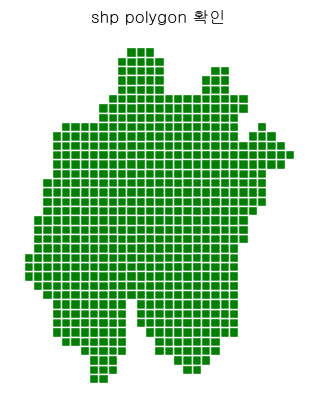

In [18]:
# 격자데이터 시각화
ax = sig.convex_hull.plot(color='green', edgecolor='w')
ax.set_title('shp polygon 확인')
ax.set_axis_off()
plt.show()

# Catboost 활용한 데이터 모델
##
## [최종 모델의 하이퍼파라미터]
### - iterations = 800
### - depth = 10
### - learning_rate = 0.2
### - l2_leaf_reg = 1

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid

from sklearn.model_selection import train_test_split
import catboost as cb
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## 최적의 하이퍼파라미터 찾기 위한 연습용 모델 코드

### valid 데이터 분류 (최적의 하이퍼파라미터를 구할 때 사용할 예정)

- valid, test, train 데이터를 random으로 돌리지 않고 일일이 날짜별로 나눠서 저장하는 이유: 
  - 'test_data_modified' 데이터와 최대한 비슷한 조건으로 하기 위해
  - 만일 random으로 돌리면 동일한 장소, 날짜에 대한 데이터이지만 시간만 다른 값들이 test, valid, train 데이터에 분포되는 경우를 미리 방지하고자 함.

In [11]:
valid_data8 = data[data['DATE']=='2023-08-20']
valid_data7 = data[data['DATE']=='2023-07-19']
valid_data6 = data[data['DATE']=='2023-06-01']

valid_data = pd.concat([valid_data6, valid_data7, valid_data8])
valid_data

,gid,DATE,TIME,RIDE_DEMAND,ALIGHT_DEMAND,DAY
0,다마9599,2023-06-01,5,1,0,Thursday
1,다마9599,2023-06-01,6,2,5,Thursday
2,다마9599,2023-06-01,7,2,7,Thursday
3,다마9599,2023-06-01,8,3,12,Thursday
4,다마9599,2023-06-01,9,2,31,Thursday
...,...,...,...,...,...,...
539401,라바0421,2023-08-20,21,0,0,Sunday
539402,라바0421,2023-08-20,22,0,0,Sunday
539403,라바0421,2023-08-20,23,0,0,Sunday
539404,라바0421,2023-08-20,0,0,0,Sunday


In [12]:
valid_data['DAY'].unique()

array(['Thursday', 'Wednesday', 'Sunday'], dtype=object)

### 임시 test 데이터 분류 (최적의 하이퍼파라미터를 구할 때 사용할 예정)
#### : 각각 일~토요일에 해당하는 6, 7, 8월 일부 데이터를 추출

In [13]:
test_dataS = data[data['DATE']=='2023-06-19']
test_dataM = data[data['DATE']=='2023-06-20']
test_dataTu = data[data['DATE']=='2023-07-05']
test_dataWe = data[data['DATE']=='2023-07-06']
test_dataTh = data[data['DATE']=='2023-07-13']
test_dataFr = data[data['DATE']=='2023-08-11']
test_dataSa = data[data['DATE']=='2023-08-12']

test_data = pd.concat([test_dataS, test_dataM, test_dataTu, test_dataWe, test_dataTh, test_dataFr, test_dataSa])
test_data

,gid,DATE,TIME,RIDE_DEMAND,ALIGHT_DEMAND,DAY
378,다마9599,2023-06-20,5,1,0,Tuesday
379,다마9599,2023-06-20,6,2,4,Tuesday
380,다마9599,2023-06-20,7,1,7,Tuesday
381,다마9599,2023-06-20,8,1,14,Tuesday
382,다마9599,2023-06-20,9,5,52,Tuesday
...,...,...,...,...,...,...
539233,라바0421,2023-08-12,21,0,0,Saturday
539234,라바0421,2023-08-12,22,0,0,Saturday
539235,라바0421,2023-08-12,23,0,0,Saturday
539236,라바0421,2023-08-12,0,0,0,Saturday


### 임시 훈련 데이터 분류 (최적의 하이퍼파라미터를 구할 때 사용할 예정)

In [14]:
#valid data 빼기
train_data = data[data['DATE']!=valid_data['DATE'].unique()[0]]
train_data = train_data[data['DATE']!=valid_data['DATE'].unique()[1]]
train_data = train_data[data['DATE']!=valid_data['DATE'].unique()[2]]

#test_data 빼기
for i in test_data['DATE'].unique():
    train_data = train_data[train_data['DATE']!=i]

C:\Users\user\AppData\Local\Temp\ipykernel_9032\146979134.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data = train_data[data['DATE']!=valid_data['DATE'].unique()[1]]
C:\Users\user\AppData\Local\Temp\ipykernel_9032\146979134.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data = train_data[data['DATE']!=valid_data['DATE'].unique()[2]]


In [15]:
train_data

,gid,DATE,TIME,RIDE_DEMAND,ALIGHT_DEMAND,DAY
21,다마9599,2023-06-02,5,4,0,Friday
22,다마9599,2023-06-02,6,7,3,Friday
23,다마9599,2023-06-02,7,6,4,Friday
24,다마9599,2023-06-02,8,11,6,Friday
25,다마9599,2023-06-02,9,5,12,Friday
...,...,...,...,...,...,...
539485,라바0421,2023-08-24,21,0,1,Thursday
539486,라바0421,2023-08-24,22,0,0,Thursday
539487,라바0421,2023-08-24,23,0,0,Thursday
539488,라바0421,2023-08-24,0,0,0,Thursday


In [16]:
# 독립 변수(X)와 종속 변수(y) 설정
warnings.filterwarnings("ignore")

x_train = train_data[['gid', 'TIME', 'DAY','ALIGHT_DEMAND']]
y_train = train_data['RIDE_DEMAND']

In [17]:
x_test = test_data[['gid', 'TIME', 'DAY','ALIGHT_DEMAND']]
y_test = test_data['RIDE_DEMAND']

x_valid = valid_data[['gid', 'TIME', 'DAY','ALIGHT_DEMAND']]
y_valid = valid_data['RIDE_DEMAND']



In [18]:
features = [0,1,2]

train_dataset = cb.Pool(x_train, y_train, cat_features = features) 
test_dataset = cb.Pool(x_test, y_test, cat_features = features)

model = cb.CatBoostRegressor(iterations=800, depth=10, learning_rate=0.2, loss_function= 'RMSE', l2_leaf_reg = 1, task_type="CPU")

model.fit(train_dataset, eval_set=(x_test, y_test), verbose_eval=10)

pred = model.predict(x_valid) 
rmse = (np.sqrt(mean_squared_error(y_valid, pred))) 
r2 = r2_score(y_valid, pred)
accuracy_test = r2*100

print("=== 최종 성능 테스트 ===")
print('RMSE: {:.2f}'.format(rmse)) 
print(f'Test Accuracy (R-squared): {r2:.2f} ({accuracy_test:.2f}%)')

0:	learn: 88.6249215	test: 96.5007789	best: 96.5007789 (0)	total: 555ms	remaining: 7m 23s
10:	learn: 38.0871890	test: 42.3621557	best: 42.3621557 (10)	total: 4.55s	remaining: 5m 26s
20:	learn: 28.4706166	test: 31.9665367	best: 31.9665367 (20)	total: 8.35s	remaining: 5m 9s
30:	learn: 25.6040266	test: 28.9558712	best: 28.9558712 (30)	total: 12.5s	remaining: 5m 10s
40:	learn: 23.6408653	test: 26.9277867	best: 26.9277867 (40)	total: 16.1s	remaining: 4m 58s
50:	learn: 22.3135857	test: 25.6410888	best: 25.6410888 (50)	total: 19.6s	remaining: 4m 47s
60:	learn: 21.1927625	test: 24.5340459	best: 24.5340459 (60)	total: 23.4s	remaining: 4m 42s
70:	learn: 20.3784673	test: 23.6714854	best: 23.6714854 (70)	total: 27.4s	remaining: 4m 40s
80:	learn: 19.5777394	test: 22.9503795	best: 22.9503795 (80)	total: 31.7s	remaining: 4m 41s
90:	learn: 19.0396156	test: 22.3558947	best: 22.3558947 (90)	total: 35.5s	remaining: 4m 36s
100:	learn: 18.6590900	test: 21.9572656	best: 21.9572656 (100)	total: 39.4s	remaini

## 모델의 손실 함수 그래프

In [305]:
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool, cv

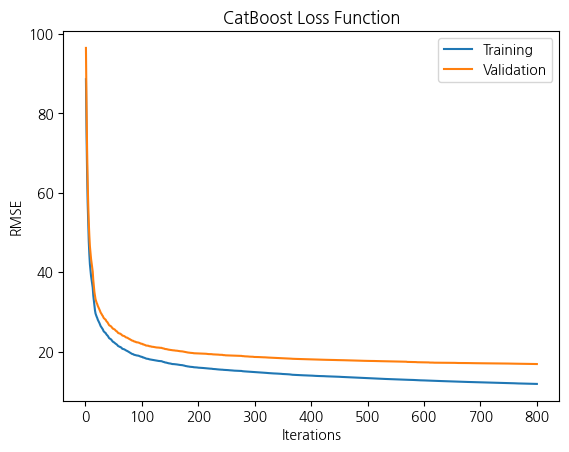

In [308]:
# 손실 함수 그래프 그리기
iterations = range(1, len(model.evals_result_['validation']['RMSE']) + 1)
plt.plot(iterations, model.evals_result_['learn']['RMSE'], label='Training')
plt.plot(iterations, model.evals_result_['validation']['RMSE'], label='Validation')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('CatBoost Loss Function')
plt.legend()
plt.savefig('모델손실함수그래프.png')    
plt.show()

## 최적의 하이퍼파라미터 모델의 검증 결과 시각화

In [309]:
import plotly.express as px

In [312]:
x_valid['Pred_RIDE_DEMAND'] = model.predict(x_valid)
x_valid['RIDE_DEMAND'] = y_valid

In [315]:
x_valid

,gid,TIME,DAY,ALIGHT_DEMAND,RIDE_DEMAND,Pred_RIDE_DEMAND
0,다마9599,5,Thursday,0,1,0.225652
1,다마9599,6,Thursday,5,2,2.136182
2,다마9599,7,Thursday,7,2,7.424163
3,다마9599,8,Thursday,12,3,6.386557
4,다마9599,9,Thursday,31,2,7.039255
...,...,...,...,...,...,...
539401,라바0421,21,Sunday,0,0,0.172525
539402,라바0421,22,Sunday,0,0,0.031716
539403,라바0421,23,Sunday,0,0,-0.014726
539404,라바0421,0,Sunday,0,0,-0.018773


In [322]:
x_valid_th6 = x_valid[x_valid['DAY']=='Thursday']
x_valid_su8 = x_valid[x_valid['DAY']=='Sunday']
x_valid_we7 = x_valid[x_valid['DAY']=='Wednesday']

In [324]:
gid = text=x_valid_th6['gid'].unique()[120]
text='6월 ['+gid+ '] 지역 목요일 버스 승차인원'

result_fig = px.line(x_valid_th6[x_valid['gid']==gid], x=x_valid_th6[x_valid['gid']==x_valid_th6['gid'].unique()[0]]['TIME'], y=["RIDE_DEMAND", "Pred_RIDE_DEMAND"])
result_fig.update_layout(
    title = text,
    margin={"l":0,"r":0,"b":0,"pad":10},
    template="plotly_dark",
    width= 800
)
result_fig.update_xaxes(
    matches=None, showticklabels=False, visible=False
)


result_fig.update_yaxes(
    title = 'RIDE_DEMAND'
)

In [330]:
gid = text=x_valid_we7['gid'].unique()[120]
text='7월 ['+gid+ '] 지역 수요일 버스 승차인원'

result_fig = px.line(x_valid_we7[x_valid['gid']==gid], x=x_valid_we7[x_valid['gid']==x_valid_we7['gid'].unique()[0]]['TIME'], y=["RIDE_DEMAND", "Pred_RIDE_DEMAND"])
result_fig.update_layout(
    title = text,
    margin={"l":0,"r":0,"b":0,"pad":10},
    template="plotly_dark",
    width= 800
)
result_fig.update_xaxes(
    matches=None, showticklabels=False, visible=False
)


result_fig.update_yaxes(
    title = 'RIDE_DEMAND'
)

In [328]:
gid = text=x_valid_su8['gid'].unique()[120]
text='8월 ['+gid+ '] 지역 일요일 버스 승차인원'

result_fig = px.line(x_valid_su8[x_valid['gid']==gid], x=x_valid_su8[x_valid['gid']==x_valid_su8['gid'].unique()[0]]['TIME'], y=["RIDE_DEMAND", "Pred_RIDE_DEMAND"])
result_fig.update_layout(
    title = text,
    margin={"l":0,"r":0,"b":0,"pad":10},
    template="plotly_dark",
    width= 800
)
result_fig.update_xaxes(
    matches=None, showticklabels=False, visible=False
)


result_fig.update_yaxes(
    title = 'RIDE_DEMAND'
)

## 최종 모델 훈련

In [279]:
# 독립 변수(X)와 종속 변수(y) 설정
warnings.filterwarnings("ignore")

x_train = data[['gid', 'TIME', 'DAY','ALIGHT_DEMAND']]
y_train = data['RIDE_DEMAND']

features = [0,1,2]

train_dataset = cb.Pool(x_train, y_train, cat_features = features) 
# test_dataset = cb.Pool(x_test, y_test, cat_features = features)

model = cb.CatBoostRegressor(iterations=800, depth=10, learning_rate=0.2, loss_function= 'RMSE', l2_leaf_reg = 1, task_type="CPU")

model.fit(train_dataset, verbose_eval=10)

0:	learn: 89.3996371	total: 393ms	remaining: 5m 14s
10:	learn: 38.0221676	total: 4.92s	remaining: 5m 52s
20:	learn: 29.8282926	total: 9.43s	remaining: 5m 49s
30:	learn: 26.2803286	total: 13.7s	remaining: 5m 39s
40:	learn: 24.0389406	total: 17.8s	remaining: 5m 29s
50:	learn: 22.9012203	total: 22.1s	remaining: 5m 23s
60:	learn: 21.8185031	total: 26s	remaining: 5m 14s
70:	learn: 21.0446259	total: 29.6s	remaining: 5m 3s
80:	learn: 20.3655408	total: 33.2s	remaining: 4m 54s
90:	learn: 19.8624850	total: 37.1s	remaining: 4m 49s
100:	learn: 19.3675042	total: 41s	remaining: 4m 43s
110:	learn: 18.7576426	total: 45.1s	remaining: 4m 39s
120:	learn: 18.4676424	total: 48.8s	remaining: 4m 34s
130:	learn: 18.1748989	total: 52.7s	remaining: 4m 29s
140:	learn: 17.9573057	total: 56.9s	remaining: 4m 26s
150:	learn: 17.6854245	total: 1m	remaining: 4m 22s
160:	learn: 17.4812566	total: 1m 5s	remaining: 4m 18s
170:	learn: 17.2060825	total: 1m 9s	remaining: 4m 15s
180:	learn: 17.0030427	total: 1m 13s	remaining:

# 최종 모델 pkl 형식으로 내보내기

In [74]:
import pickle

In [19]:
pickle.dump(model, open("RideDemand_model_최종.pkl", 'wb'))

In [3]:
# 모델을 pkl 파일로 저장
with open('catboost_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

## pkl 형식 모델 다시 가져와서 최종 테스트 데이터 승차인원 예측하기

In [284]:
# 독립 변수(X)와 종속 변수(y) 설정
data_test_x = data_test[['gid', 'TIME', 'DAY','ALIGHT_DEMAND']]

In [281]:
ride_demand_model = pickle.load(open("RideDemand_model_김아윤.pkl", 'rb'))

In [285]:
final_pred = ride_demand_model.predict(data_test_x)

In [286]:
final_pred

array([0.78075574, 2.23452909, 2.73750837, ..., 0.10456973, 0.07952873,
       0.07952873])

In [292]:
data_test['PRED_RIDE_DEMAND'] = final_pred
del data_test['DAY']  # 추가했던 요일 데이터 지우기
data_test

,gid,DATE,TIME,ALIGHT_DEMAND,PRED_RIDE_DEMAND
0,다마9599,2023-06-24,5,0,0.780756
1,다마9599,2023-06-24,6,1,2.234529
2,다마9599,2023-06-24,7,0,2.737508
3,다마9599,2023-06-24,8,1,3.175219
4,다마9599,2023-06-24,9,5,3.547135
...,...,...,...,...,...
161842,라바0421,2023-08-31,21,1,0.045138
161843,라바0421,2023-08-31,22,0,0.082919
161844,라바0421,2023-08-31,23,0,0.104570
161845,라바0421,2023-08-31,0,0,0.079529


In [293]:
data_test.to_csv('test_data_result.csv')